# Bipedal_Walker
## Deep Deterministic Policy Gradient (DDPG) TD3 variant

In [1]:
# import standard libraries
import os
import base64
import random
import time
from collections import deque

# import third-party libraries
import gymnasium as gym
import numpy as np
import pandas as pd

import imageio
import IPython
from IPython.display import clear_output
from IPython import display
import PIL.Image
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1070 (UUID: GPU-19cef1c2-e216-e824-c98e-660394f8a4bb)


In [3]:
print(tf.config.list_logical_devices())
print(tf.config.list_physical_devices())

[LogicalDevice(name='/device:CPU:0', device_type='CPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## create img dir

In [4]:
try: 
    os.mkdir('img') 
except OSError as error:
    print('directory "img" was not created') 

directory "img" was not created


## Constants

In [5]:
MINIBATCH_SIZE = 64   # mini-batch size
TAU = 0.005           # soft update parameter

# Hyperparameters
MEMORY_SIZE = 100_000     # size of memory buffer
GAMMA = 0.99              # discount factor
ALPHA = 1e-4              # learning rate
NUM_STEPS_FOR_UPDATE = 2  # perform a learning update every C time steps

HIDDEN_LAYER_SIZE = 64 #512 # 64

## Load the Environment

In [6]:
env = gym.make('BipedalWalker-v3', render_mode="rgb_array")

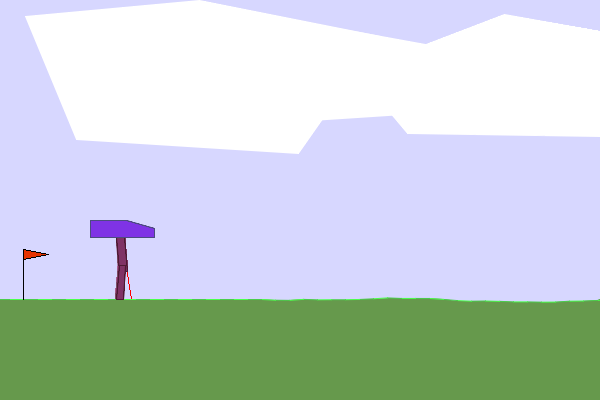

In [7]:
env.reset()
PIL.Image.fromarray(env.render())

In [8]:
state_size = env.observation_space.shape
num_actions = env.action_space.shape[0]

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (24,)
Number of actions: 4


In [9]:
# Reset the environment and get the initial state.
initial_state, info = env.reset()

In [10]:
initial_state

array([ 2.7474589e-03, -9.9407407e-06,  7.7328930e-04, -1.5999932e-02,
        9.2013747e-02, -1.0204790e-03,  8.6023867e-01,  2.1571729e-03,
        1.0000000e+00,  3.2419425e-02, -1.0204087e-03,  8.5378814e-01,
        7.2169217e-04,  1.0000000e+00,  4.4081402e-01,  4.4582012e-01,
        4.6142277e-01,  4.8955020e-01,  5.3410280e-01,  6.0246104e-01,
        7.0914888e-01,  8.8593185e-01,  1.0000000e+00,  1.0000000e+00],
      dtype=float32)

|Num|Name|Min|Max|
|---|---|---|---|
|0|Hip_1 (Torque / Velocity)|-1|+1|
|1|Knee_1 (Torque / Velocity)|-1|+1|
|2|Hip_2 (Torque / Velocity)|-1|+1|
|3|Knee_2 (Torque / Velocity)|-1|+1|

In [11]:
env.action_space.high

array([1., 1., 1., 1.], dtype=float32)

### ReplayBuffer Class

In [12]:
class ReplayBuffer(object):

    def __init__(self, buffer_size, random_seed=123):
        """
        The right side of the deque contains the most recent experiences 
        """
        self.buffer_size = buffer_size
        self.count = 0
        self.buffer = deque()
        random.seed(random_seed)

    def add(self, s, a, r, t, s2):
        experience = (s, a, r, t, s2)
        if self.count < self.buffer_size: 
            self.buffer.append(experience)
            self.count += 1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.count

    def sample_batch(self, batch_size):
        batch = []

        if self.count < batch_size:
            batch = random.sample(self.buffer, self.count)
        else:
            batch = random.sample(self.buffer, batch_size)

        s_batch = np.array([_[0] for _ in batch])
        a_batch = np.array([_[1] for _ in batch])
        r_batch = np.array([_[2] for _ in batch])
        t_batch = np.array([_[3] for _ in batch])
        s2_batch = np.array([_[4] for _ in batch])

        return s_batch, a_batch, r_batch, t_batch, s2_batch

    def clear(self):
        self.buffer.clear()
        self.count = 0

### Critic Network
The critic Network take in inputs, the env states and actions to predict a q_value (Q(s,a))

In [13]:
class Critic(tf.keras.Model):
    def __init__(self):
        super(Critic, self).__init__()
        self.f1 = Dense(HIDDEN_LAYER_SIZE, activation='relu')
        self.d1 = Dropout(0.2) # Add a dropout rate of 0.2
        self.f2 = Dense(HIDDEN_LAYER_SIZE, activation='relu')
        self.d2 = Dropout(0.2) # Add a dropout rate of 0.2
        self.v =  Dense(1, activation=None)

    def call(self, input_state, action):
        x = self.f1(tf.concat([input_state, action], axis=1))
        x = self.d1(x)
        x = self.f2(x)
        x = self.d2(x)
        x = self.v(x)
        return x

### Actor Network
The actor network take in input, the env states to predict actions

In [14]:
class Actor(tf.keras.Model):
    def __init__(self, no_action):
        super(Actor, self).__init__()    
        self.f1 = Dense(HIDDEN_LAYER_SIZE, activation='relu')
        self.d1 = Dropout(0.2) # Add a dropout rate of 0.2
        self.f2 = Dense(HIDDEN_LAYER_SIZE, activation='relu')
        self.d2 = Dropout(0.2) # Add a dropout rate of 0.2
        self.mu =  Dense(no_action, activation='tanh')

    def call(self, state):
        x = self.f1(state)
        x = self.d1(x)
        x = self.f2(x)
        x = self.d2(x)
        x = self.mu(x) 
        return x

### Agent

In [15]:
class Agent():
    def __init__(self, n_action= len(env.action_space.high)):
        self.actor_main = Actor(n_action)
        self.actor_target = Actor(n_action)
        self.critic_main = Critic()
        self.critic_main2 = Critic()
        self.critic_target = Critic()
        self.critic_target2 = Critic()
        self.batch_size = MINIBATCH_SIZE
        self.n_actions = n_action
        self.a_opt = Adam(ALPHA)
        self.c_opt1 = Adam(0.002)
        self.c_opt2 = Adam(0.002)
        self.memory = ReplayBuffer(MEMORY_SIZE)
        self.trainstep = 0
        # self.replace = 5
        self.gamma = GAMMA
        self.min_action = env.action_space.low[0]
        self.max_action = env.action_space.high[0]
        self.warmup = 200
        self.actor_update_steps = NUM_STEPS_FOR_UPDATE
        self.tau = TAU
        self.actor_target.compile(optimizer=self.a_opt)
        self.critic_target.compile(optimizer=self.c_opt1)
        self.critic_target2.compile(optimizer=self.c_opt2)

    def act(self, state, evaluate=False):
        if self.trainstep > self.warmup:
          evaluate = True
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        actions = self.actor_main(state)
        if not evaluate:
            actions += tf.random.normal(shape=[self.n_actions], mean=0.0, stddev=0.1)

        actions = self.max_action * (tf.clip_by_value(actions, self.min_action, self.max_action))
        return actions[0]
    
    def update_target(self, tau=None):
        if tau is None:
            tau = self.tau

        weights1 = []
        targets1 = self.actor_target.weights
        for i, weight in enumerate(self.actor_main.weights):
            weights1.append(weight * tau + targets1[i]*(1-tau))
        self.actor_target.set_weights(weights1)

        weights2 = []
        targets2 = self.critic_target.weights
        for i, weight in enumerate(self.critic_main.weights):
            weights2.append(weight * tau + targets2[i]*(1-tau))
        self.critic_target.set_weights(weights2)
        
    def train(self):
        if self.memory.size() < self.batch_size:
            return 
        states, actions, rewards, dones, next_states = self.memory.sample_batch(self.batch_size)
  
        states = tf.convert_to_tensor(states, dtype= tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype= tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype= tf.float32)
        actions = tf.convert_to_tensor(actions, dtype= tf.float32)
        # dones = tf.convert_to_tensor(dones, dtype= tf.bool) # = 1 - dones

        with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
            
            target_actions = self.actor_target(next_states)
            target_actions += tf.clip_by_value(tf.random.normal(shape=[*np.shape(target_actions)], mean=0.0, stddev=0.2), -0.5, 0.5)
            target_actions = self.max_action * (tf.clip_by_value(target_actions, self.min_action, self.max_action))
            
            target_next_state_values = tf.squeeze(self.critic_target(next_states, target_actions), 1)
            target_next_state_values2 = tf.squeeze(self.critic_target2(next_states, target_actions), 1)

            critic_value = tf.squeeze(self.critic_main(states, actions), 1)
            critic_value2 = tf.squeeze(self.critic_main2(states, actions), 1)

            # we alaways get the minimum in order to not surestimate the value
            next_state_target_value = tf.math.minimum(target_next_state_values, target_next_state_values2)

            target_values = rewards + (self.gamma * target_next_state_values * dones)
            critic_loss1 = tf.keras.losses.MSE(target_values, critic_value)
            critic_loss2 = tf.keras.losses.MSE(target_values, critic_value2)

        grads1 = tape1.gradient(critic_loss1, self.critic_main.trainable_variables)
        grads2 = tape2.gradient(critic_loss2, self.critic_main2.trainable_variables)
        self.c_opt1.apply_gradients(zip(grads1, self.critic_main.trainable_variables))
        self.c_opt2.apply_gradients(zip(grads2, self.critic_main2.trainable_variables))

        self.trainstep +=1

        if self.trainstep % self.actor_update_steps == 0:
            with tf.GradientTape() as tape3:
                new_policy_actions = self.actor_main(states)
                actor_loss = -self.critic_main(states, new_policy_actions)
                actor_loss = tf.math.reduce_mean(actor_loss)

            grads3 = tape3.gradient(actor_loss, self.actor_main.trainable_variables)
            self.a_opt.apply_gradients(zip(grads3, self.actor_main.trainable_variables))
      
        self.update_target()

        
    def savexp(self, state, next_state, action, done, reward):
        self.memory.add(state, action, reward, done, next_state)

In [16]:
with tf.device('/device:CPU:0'):
    start = time.time()

    # Create Agent
    tf.random.set_seed(336699)
    agent = Agent(env.action_space.shape[0])

    episods = 500
    max_num_timesteps = 1600

    total_point_history = []

    num_p_av = 100    # number of total points to use for averaging
  
    for i in range(episods):
        # Reset the environment to the initial state and get the initial state
        state, _ = env.reset()
        total_points = 0
    
        for t in range(max_num_timesteps):
            # From the current state S choose an action A
            action = agent.act(state)
            # Take action A and receive reward R and the next state S'
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            # Store experience tuple (S,S',A,T,R) in the memory buffer.
            agent.savexp(state, next_state, action, done, reward)
            # Train models
            agent.train()

            # Update total reward and current state
            state = next_state.copy()
            total_points += reward

            if done:
                break
      
        total_point_history.append(total_points)
        av_latest_points = np.mean(total_point_history[-num_p_av:])

        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

        if (i+1) % num_p_av == 0:
            print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

        # We will consider that the environment is solved if we get an
        # average of 300 points in the last 100 episodes.
        if av_latest_points >= env.spec.reward_threshold:
            print(f"\n\nEnvironment solved in {i+1} episodes!")
            # agent.q_network.save(SAVE_PATH)
            break
    tot_time = time.time() - start
    print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | Total point average of the last 100 episodes: -114.01
Episode 200 | Total point average of the last 100 episodes: -119.83
Episode 300 | Total point average of the last 100 episodes: -129.07
Episode 400 | Total point average of the last 100 episodes: -122.68
Episode 500 | Total point average of the last 100 episodes: -126.92

Total Runtime: 5855.40 s (97.59 min)


### Plot utils

In [17]:
def update_plot(frame_number, state, num_iteration):
    action = agent.act(state)
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    frame = env.render()

    # converting state to plot in order to stylize it
    fig = Figure()
    canvas = FigureCanvas(fig)
    ax = fig.add_subplot(1,1,1)
    ax.imshow(frame)
    ax.axis('off')
    ax.set_title(f"Timestep=({frame_number})")
    canvas.draw()

    # reconverting plot to state
    size = fig.get_size_inches() * fig.dpi
    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(int(size[1]), int(size[0]), 3)

    if done:
        state, _ = env.reset()
        num_iteration -= 1
        time.sleep(0.5)
        frame_number = 0
    else:
        frame_number += 1
    return image, frame_number, state, num_iteration

In [18]:
def save():
    """Saves an animated GIF of the agent's performance."""
    state, _ = env.reset()
    frame = env.render()
    num_iteration = 5
    images = []
    frame_number = 0
    while num_iteration > 0:
        print(f"{(5 - num_iteration)+1}/{5}", end="\r")
        frame, frame_number, state, num_iteration = update_plot(frame_number, state, num_iteration)
        images.append(Image.fromarray(frame))
    print("\nSaving..............", end="\r")            
    images[0].save('img/bipedal_walker.gif', format='GIF', save_all=True, append_images=images[1:], duration=50, loop=0)
    print("Saved                            ")

In [19]:
def plot_history(reward_history, rolling_window=20, lower_limit=None, upper_limit=None, plot_rw=True, plot_rm=True):
    """
    Function to plot reward history and its rolling mean with some optional arguments.

    Args:
        reward_history (list): A list of rewards for each episode.
        rolling_window (int): The number of episodes for computing the rolling mean.
        lower_limit (int): Starting episode index for plotting.
        upper_limit (int): Ending episode index for plotting.
        plot_rw (bool): A flag for plotting raw reward history.
        plot_rm (bool): A flag for plotting rolling mean reward history.

    Returns:
        None
    """
    
    # If lower_limit and upper_limit are not provided, use the whole reward_history
    if lower_limit is None or upper_limit is None:
        rh = reward_history
        xs = [x for x in range(len(reward_history))]
    else:
        rh = reward_history[lower_limit:upper_limit]
        xs = [x for x in range(lower_limit,upper_limit)]
   
    # Create a DataFrame and calculate the rolling mean
    df = pd.DataFrame(rh)
    rollingMean = df.rolling(rolling_window).mean()

    # Plot the results
    plt.figure(figsize=(10,7), facecolor='white')
    
    if plot_rw:
        plt.plot(xs, rh, linewidth=1, color='cyan')
    if plot_rm:
        plt.plot(xs, rollingMean, linewidth=2, color='magenta')

    text_color = 'black'
        
    ax = plt.gca()
    ax.set_facecolor('black')
    plt.grid()

    plt.xlabel('Episode', color=text_color, fontsize=30)
    plt.ylabel('Total Points', color=text_color, fontsize=30)
    yNumFmt = mticker.StrMethodFormatter('{x:,}')
    ax.yaxis.set_major_formatter(yNumFmt)
    ax.tick_params(axis='x', colors=text_color)
    ax.tick_params(axis='y', colors=text_color)
    plt.show()

In [20]:
def embed_gif(filename):
    """Embeds an mp4 file in the notebook."""
    gif = open(filename,'rb').read()
    b64 = base64.b64encode(gif)
    tag = '''<img width="840" height="480"  src="data:img/gif;base64,{0}"/>'''.format(b64.decode())
    return IPython.display.HTML(tag)

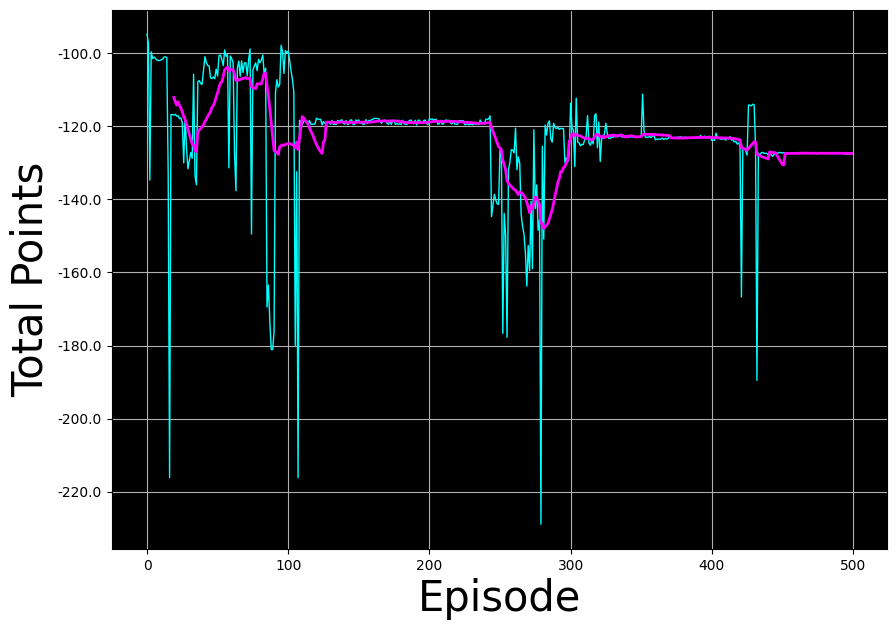

In [21]:
# Plot the point history
plot_history(total_point_history)

In [22]:
save()

5/5
Saved                            


In [23]:
filename = "./img/bipedal_walker.gif"
embed_gif(filename)